In [ ]:
!pip install selectivesearch

  Preparing metadata (setup.py) ... done
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4336 sha256=dff44b1de7dee343323c21d7aab41f0d90f57ed530bd3c6d728da4d6c130ddbb
  Stored in directory: /root/.cache/pip/wheels/02/7c/60/bdd2e1419980f70e30aba939372bdbde5baf8d75a59ba4bc66
Successfully built selectivesearch


In [ ]:
import selectivesearch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array
import time
from google.colab import files
import os

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  image_path = fn #  Use the uploaded image

# Load image and resize
image_path = os.path.join('/content', image_path) # Construct the full path
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Could not load image from {image_path}. Please ensure the file exists, is not corrupted, and is in a supported format.")
    exit()

# Print image shape for debugging
print(f"Image shape: {image.shape}") # Check if image loaded correctly

image = cv2.resize(image, (600, 400))  # Resize for faster processing
orig = image.copy()

Saving Screenshot 2025-05-06 183846.png to Screenshot 2025-05-06 183846.png
User uploaded file "Screenshot 2025-05-06 183846.png" with length 184443 bytes
Image shape: (203, 528, 3)


--- 3.19810152053833 seconds ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


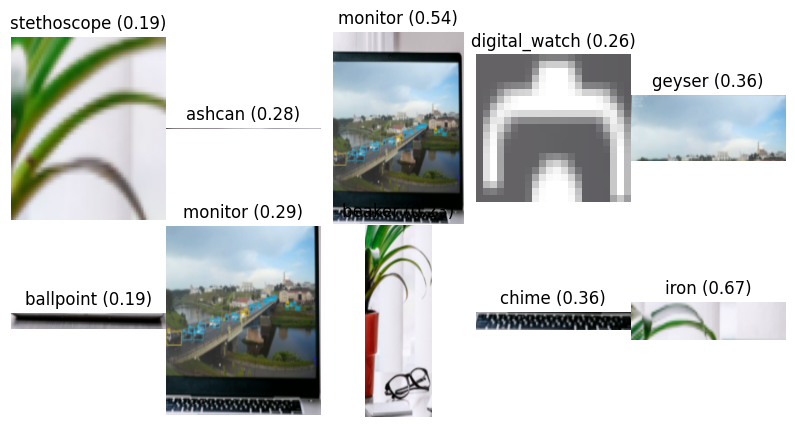

In [ ]:
# Selective Search
start_time = time.time()
img_lbl, regions = selectivesearch.selective_search(image, scale=500, sigma=0.9, min_size=10)
print("--- %s seconds ---" % (time.time() - start_time))

candidates = set()
for r in regions:
    if r['rect'] in candidates:
        continue
    if r['size'] < 200:
        continue
    x, y, w, h = r['rect']
    if w == 0 or h == 0:
        continue
    candidates.add(r['rect'])

# Initialize ResNet50 model
model = ResNet50(weights='imagenet')

fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(10, 5))
plt.subplots_adjust(wspace=0, hspace=0)
axs = axs.ravel()

for i, region in enumerate(list(candidates)[:10]):
    x, y, w, h = region

    cropped_image = orig[y:y + h, x:x + w]

    if cropped_image.size == 0:  # Skip empty crops
        continue

    resized_image = cv2.resize(cropped_image, (224, 224))  # Resize to model input size
    img = img_to_array(resized_image)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    preds = model.predict(img)
    decoded_preds = decode_predictions(preds, top=1)[0]
    label = decoded_preds[0][1]
    confidence = decoded_preds[0][2]

    axs[i].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    axs[i].set_title(f"{label} ({confidence:.2f})")
    axs[i].axis('off')

plt.show()
